# StyleGAN2 + CLIP Finetuning (StyleGAN-NADA)

**What we do:** Finetune StyleGAN2 (faces) with CLIP so that generated images move toward a target text domain ("a drawn anime style face") while keeping the source domain ("a photo of a face"). Uses *directional* CLIP loss: align image direction ΔI with text direction ΔT.

**Steps:**
- **1** — Mount Drive, create folders (models, checkpoints, output)
- **2** — Install pip deps (ftfy, regex, tqdm, gdown, Ninja)
- **3** — Clone StyleGAN2 + CLIP repos to Drive, download weights
- **4** — Load StyleGAN2 generator (FFHQ)
- **5** — Load CLIP (ViT-B/32)
- **6** — Sanity check: generate face, CLIP similarity
- **7** — Split into G_frozen (no grad) and G_train (synthesis trainable)
- **8** — Define source/target text prompts, directional CLIP loss
- **9** — Training loop, save checkpoints to Drive
- **10** — Generate samples with trained G_train

## Step 1: Storage and folder structure

Choose where to store models, checkpoints, and output:

- **Google Drive** — set `USE_GOOGLE_DRIVE = True`. Drive will be mounted; all data persists across Colab sessions.
- **Local (content folder)** — set `USE_GOOGLE_DRIVE = False`. Uses `/content/StyleGAN_NADA` with the same folder structure (models, repos, checkpoints, output). Data is lost when the session ends.

In [2]:
# Set to True to use Google Drive; False to use local /content/StyleGAN_NADA (same folder structure)
USE_GOOGLE_DRIVE = False #True/False

In [3]:
import os

if USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount("/content/drive")
    PROJECT_BASE = "/content/drive/MyDrive/StyleGAN_NADA"
    storage_label = "Google Drive"
else:
    PROJECT_BASE = "/content/StyleGAN_NADA"
    storage_label = "local (content)"

MODELS_DIR = os.path.join(PROJECT_BASE, "models")
REPOS_DIR = os.path.join(PROJECT_BASE, "repos")
CHECKPOINTS_DIR = os.path.join(PROJECT_BASE, "checkpoints/1")
OUTPUT_DIR = os.path.join(PROJECT_BASE, "output")

for d in [MODELS_DIR, REPOS_DIR, CHECKPOINTS_DIR, OUTPUT_DIR]:
    os.makedirs(d, exist_ok=True)

print(f"Storage: {storage_label}")
print("  models:", MODELS_DIR)
print("  repos:", REPOS_DIR)
print("  checkpoints:", CHECKPOINTS_DIR)
print("  output:", OUTPUT_DIR)

Storage: local (content)
  models: /content/StyleGAN_NADA/models
  repos: /content/StyleGAN_NADA/repos
  checkpoints: /content/StyleGAN_NADA/checkpoints/1
  output: /content/StyleGAN_NADA/output


## Step 2: Install dependencies and imports

Install only pip deps (ftfy, regex, tqdm, gdown, Ninja). CLIP code is taken from the repo on Drive (Step 3), not from pip.

In [4]:
# Dependencies (Colab already has torch, torchvision). CLIP repo is on Drive (Step 3).
!pip install -q ftfy regex tqdm gdown Ninja

In [5]:
import torch
import torch.nn as nn
import sys
import random
import numpy as np
from pathlib import Path

print(f"CUDA: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'none'}")

CUDA: True
GPU: Tesla T4


In [6]:
# Fix random seeds so everyone gets the same results (like in StyleGAN_HW)
SEED = 3456
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
print(f"Seeds fixed to {SEED} for reproducibility.")

Seeds fixed to 3456 for reproducibility.


## Step 3: Repos and weights on Drive (all in one place)

Clone repos to Drive only if not already present, then download weights. We work from disk so we don't re-download each session.
- **StyleGAN2**: repo `repos/stylegan2-pytorch`, weights in `models/`
- **CLIP**: repo `repos/CLIP`, weights in `models/clip_cache/`

In [7]:
# Repos on Drive: clone only if not present
STYLEGAN2_ROOT = os.path.join(REPOS_DIR, "stylegan2-pytorch")
if not os.path.isfile(os.path.join(STYLEGAN2_ROOT, "model.py")):
    print("StyleGAN2 repo not on disk, cloning...")
    !git clone https://github.com/rosinality/stylegan2-pytorch.git "{STYLEGAN2_ROOT}"
    print("StyleGAN2 done.")
else:
    print("StyleGAN2 repo already on disk at", STYLEGAN2_ROOT)

CLIP_ROOT = os.path.join(REPOS_DIR, "CLIP")
if not os.path.isfile(os.path.join(CLIP_ROOT, "clip", "model.py")):
    print("CLIP repo not on disk, cloning...")
    !git clone https://github.com/openai/CLIP.git "{CLIP_ROOT}"
    print("CLIP done.")
else:
    print("CLIP repo already on disk at", CLIP_ROOT)

sys.path.insert(0, STYLEGAN2_ROOT)
sys.path.insert(0, CLIP_ROOT)

StyleGAN2 repo not on disk, cloning...
Cloning into '/content/StyleGAN_NADA/repos/stylegan2-pytorch'...
remote: Enumerating objects: 395, done.
remote: Total 395 (delta 0), reused 0 (delta 0), pack-reused 395 (from 1)
Receiving objects: 100% (395/395), 122.51 MiB | 29.02 MiB/s, done.
Resolving deltas: 100% (205/205), done.
StyleGAN2 done.
CLIP repo not on disk, cloning...
Cloning into '/content/StyleGAN_NADA/repos/CLIP'...
remote: Enumerating objects: 256, done.
remote: Total 256 (delta 0), reused 0 (delta 0), pack-reused 256 (from 1)
Receiving objects: 100% (256/256), 8.87 MiB | 16.95 MiB/s, done.
Resolving deltas: 100% (136/136), done.
CLIP done.


In [8]:
import gdown

# Download weights only if not already on disk (avoid re-downloading from external sources)
FILES = {
    "stylegan2-ffhq-config-f.pt": "1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT",
}

for name, file_id in FILES.items():
    path = os.path.join(MODELS_DIR, name)
    if os.path.isfile(path):
        print(f"Already on disk, skip: {name}")
        continue
    print(f"Downloading {name}...")
    gdown.download(
        f"https://drive.google.com/uc?id={file_id}",
        path,
        quiet=False,
    )

# CLIP: download to Drive if not cached yet (same as other models)
import clip
CLIP_CACHE = os.path.join(MODELS_DIR, "clip_cache")
os.makedirs(CLIP_CACHE, exist_ok=True)
_device = "cuda" if torch.cuda.is_available() else "cpu"
clip.load("ViT-B/32", device=_device, download_root=CLIP_CACHE)
print("CLIP weights cached in:", CLIP_CACHE)
print("Weights path:", MODELS_DIR)

Downloading...
From (original): https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT
From (redirected): https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT&confirm=t&uuid=1f69e4fc-8c86-4bff-a96d-94acbf36e1f8
To: /content/StyleGAN_NADA/models/stylegan2-ffhq-config-f.pt
100%|██████████| 381M/381M [00:01<00:00, 234MB/s] 
100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 99.4MiB/s]


CLIP weights cached in: /content/StyleGAN_NADA/models/clip_cache
Weights path: /content/StyleGAN_NADA/models


## Step 4: Load StyleGAN2 generator

Load the StyleGAN2 Generator from the repo on Drive and load pretrained FFHQ weights from Drive.

In [10]:
from model import Generator

device = "cuda" if torch.cuda.is_available() else "cpu"
latent_dim = 512
generator = Generator(size=1024, style_dim=latent_dim, n_mlp=8).to(device)

ckpt_path = os.path.join(MODELS_DIR, "stylegan2-ffhq-config-f.pt")
ckpt = torch.load(ckpt_path, map_location=device)
generator.load_state_dict(ckpt["g_ema"])
generator.eval()

print("StyleGAN2 generator loaded from", ckpt_path)

StyleGAN2 generator loaded from /content/StyleGAN_NADA/models/stylegan2-ffhq-config-f.pt


## Step 5: Load CLIP

Load CLIP (ViT-B/32) from cache (downloaded in Step 3).

In [11]:
import clip

CLIP_CACHE = os.path.join(MODELS_DIR, "clip_cache")
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device, download_root=CLIP_CACHE)
clip_model.eval()

# Quick check: encode a text
with torch.no_grad():
    t = clip.tokenize(["a photo of a face"]).to(device)
    E = clip_model.encode_text(t)
print("CLIP loaded. Text embedding shape:", E.shape)

CLIP loaded. Text embedding shape: torch.Size([1, 512])


## Step 6: Sanity check — generate image, CLIP

Generate one face with StyleGAN2, display it, and compare the image with the text "a photo of a face" via CLIP (cosine similarity).

/content/StyleGAN_NADA/repos/stylegan2-pytorch/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.9.0+cu126. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


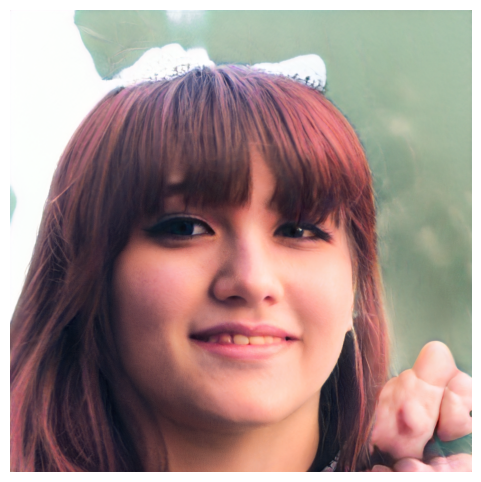

StyleGAN2 output shape: torch.Size([1, 3, 1024, 1024])
CLIP similarity (image vs 'a photo of a face'): 0.2520
(1.0 = perfect match; typical face photo is ~0.25–0.35)


In [12]:
import matplotlib.pyplot as plt

# 1. Generate one face
z = torch.randn(1, latent_dim, device=device)
with torch.no_grad():
    img, _ = generator([z], input_is_latent=False)
# img: (1, 3, 1024, 1024), range [-1, 1]

# 2. Display
def show_img(tensor):
    x = (tensor.clamp(-1, 1) + 1) / 2
    x = x.squeeze(0).permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(6, 6))
    plt.imshow(x)
    plt.axis("off")
    plt.show()

show_img(img)
print("StyleGAN2 output shape:", img.shape)

# 3. CLIP: compare image with text "a photo of a face" (use official clip_preprocess)

# Tensor-only preprocess: mean/std from CLIP's native preprocess, preserves gradients
from torchvision.transforms import Normalize
for _t in clip_preprocess.transforms:
    if isinstance(_t, Normalize):
        _clip_mean, _clip_std = _t.mean, _t.std
        break
else:
    raise RuntimeError("CLIP preprocess has no Normalize layer")

def preprocess_for_clip(images):
    """images: (B, 3, H, W) in [-1, 1]. Same as CLIP preprocess, tensor-only (gradients flow)."""
    images = torch.nn.functional.interpolate(images, size=(224, 224), mode="bilinear")
    images = (images.clamp(-1, 1) + 1) / 2
    mean = torch.tensor(_clip_mean, device=images.device).view(1, 3, 1, 1)
    std = torch.tensor(_clip_std, device=images.device).view(1, 3, 1, 1)
    return (images - mean) / std

text_prompt = "a photo of a face"
with torch.no_grad():
    img_clip = preprocess_for_clip(img)
    img_enc = clip_model.encode_image(img_clip)
    text_enc = clip_model.encode_text(clip.tokenize([text_prompt]).to(device))
    img_enc = img_enc / img_enc.norm(dim=-1, keepdim=True)
    text_enc = text_enc / text_enc.norm(dim=-1, keepdim=True)
    similarity = (img_enc * text_enc).sum(dim=-1).item()

print(f"CLIP similarity (image vs '{text_prompt}'): {similarity:.4f}")
print("(1.0 = perfect match; typical face photo is ~0.25–0.35)")

## Step 7: G_frozen and G_train

Two generators: G_frozen (no gradients) and G_train (only synthesis is trainable; mapping is frozen so both get the same w from z).

In [13]:
# List all generator layer names (to see what to freeze in G_train)
for name, _ in generator.named_parameters():
    print(name)

style.1.weight
style.1.bias
style.2.weight
style.2.bias
style.3.weight
style.3.bias
style.4.weight
style.4.bias
style.5.weight
style.5.bias
style.6.weight
style.6.bias
style.7.weight
style.7.bias
style.8.weight
style.8.bias
input.input
conv1.conv.weight
conv1.conv.modulation.weight
conv1.conv.modulation.bias
conv1.noise.weight
conv1.activate.bias
to_rgb1.bias
to_rgb1.conv.weight
to_rgb1.conv.modulation.weight
to_rgb1.conv.modulation.bias
convs.0.conv.weight
convs.0.conv.modulation.weight
convs.0.conv.modulation.bias
convs.0.noise.weight
convs.0.activate.bias
convs.1.conv.weight
convs.1.conv.modulation.weight
convs.1.conv.modulation.bias
convs.1.noise.weight
convs.1.activate.bias
convs.2.conv.weight
convs.2.conv.modulation.weight
convs.2.conv.modulation.bias
convs.2.noise.weight
convs.2.activate.bias
convs.3.conv.weight
convs.3.conv.modulation.weight
convs.3.conv.modulation.bias
convs.3.noise.weight
convs.3.activate.bias
convs.4.conv.weight
convs.4.conv.modulation.weight
convs.4.conv.mo

In [14]:
import copy

G_frozen = copy.deepcopy(generator)
for p in G_frozen.parameters():
    p.requires_grad = False

G_train = copy.deepcopy(generator)
for name, p in G_train.named_parameters():
    if "style" in name:
        p.requires_grad = False

n_trainable = sum(p.numel() for p in G_train.parameters() if p.requires_grad)
print("G_frozen: all params frozen. G_train:", n_trainable, "trainable params (synthesis only).")

G_frozen: all params frozen. G_train: 28268812 trainable params (synthesis only).


## Step 8: Text prompts and directional CLIP loss

**Идея:** Обучаем G_train так, чтобы *направление* изменения изображения (от «фото» к «аниме») совпадало с *направлением* в пространстве текстов CLIP.

**Формула (directional CLIP loss):**
- $\Delta T = E_T(\text{target}) - E_T(\text{source})$ — направление между целевым и исходным текстом в CLIP (разность эмбеддингов)
- $\Delta I = E_I(G_{\text{train}}(w)) - E_I(G_{\text{frozen}}(w))$ — направление между «обученным» и «замороженным» изображением (одно и то же w, разный генератор)
- $L = 1 - \cos(\Delta I, \Delta T) = 1 - \frac{\Delta I \cdot \Delta T}{\|\Delta I\| \cdot \|\Delta T\|}$

**Что это даёт:** Минимизируем L → cos(ΔI, ΔT) → 1 → ΔI выравнивается по ΔT. То есть изображение движется в сторону target-текста так же, как текст target отличается от source.

In [15]:
text_source = "a photo of a face"
text_target = "a drawn anime style face"

with torch.no_grad():
    t_s = clip.tokenize([text_source]).to(device)
    t_t = clip.tokenize([text_target]).to(device)
    E_t_source = clip_model.encode_text(t_s)
    E_t_target = clip_model.encode_text(t_t)


def directional_clip_loss(img_frozen, img_train, E_t_source, E_t_target, clip_model, preprocess_fn):
    img_f = preprocess_fn(img_frozen)
    img_t = preprocess_fn(img_train)
    E_i_frozen = clip_model.encode_image(img_f)
    E_i_train = clip_model.encode_image(img_t)
    delta_I = E_i_train - E_i_frozen
    delta_T = E_t_target - E_t_source
    delta_T = delta_T.expand(delta_I.shape[0], -1)
    delta_I_norm = delta_I / (delta_I.norm(dim=-1, keepdim=True) + 1e-8)
    delta_T_norm = delta_T / (delta_T.norm(dim=-1, keepdim=True) + 1e-8)
    cos_sim = (delta_I_norm * delta_T_norm).sum(dim=-1)
    return 1 - cos_sim.mean()

print("Text prompts encoded. directional_clip_loss ready.")

Text prompts encoded. directional_clip_loss ready.


## Step 9: Training loop

Sample z, get w from frozen mapping, forward through G_frozen and G_train, minimize directional loss. Save checkpoints to Drive.

In [16]:
from torch.optim import AdamW
from tqdm import tqdm

optimizer = AdamW(
    filter(lambda p: p.requires_grad, G_train.parameters()),
    lr=0.002,
)

n_iter = 500
batch_size = 2
log_every = 50

for i in tqdm(range(n_iter)):
    z = torch.randn(batch_size, latent_dim, device=device)
    with torch.no_grad():
        w = G_frozen.style(z)
    img_frozen, _ = G_frozen([w], input_is_latent=True)
    img_train, _ = G_train([w], input_is_latent=True)
    loss = directional_clip_loss(
        img_frozen.detach(), img_train,
        E_t_source, E_t_target,
        clip_model, preprocess_for_clip,
    )
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i + 1) % log_every == 0:
        print(f"Iter {i+1}, loss: {loss.item():.4f}")
        epoch = i + 1
        epoch_dir = os.path.join(CHECKPOINTS_DIR, str(epoch))
        os.makedirs(epoch_dir, exist_ok=True)
        torch.save({
            "G_train": G_train.state_dict(),
            "iter": epoch,
            "source": text_source,
            "target": text_target,
        }, os.path.join(epoch_dir, f"checkpoint_{epoch}.pt"))

print("Training done. Checkpoints in", CHECKPOINTS_DIR)

 10%|█         | 50/500 [00:27<04:57,  1.51it/s]

Iter 50, loss: 0.7817


 20%|██        | 100/500 [00:55<04:23,  1.52it/s]

Iter 100, loss: 0.7373


 30%|███       | 150/500 [01:22<03:45,  1.55it/s]

Iter 150, loss: 0.7163


 40%|████      | 200/500 [01:49<03:15,  1.53it/s]

Iter 200, loss: 0.7017


 50%|████▉     | 249/500 [02:16<02:18,  1.81it/s]

Iter 250, loss: 0.7212


 60%|██████    | 300/500 [02:44<02:10,  1.53it/s]

Iter 300, loss: 0.7070


 70%|███████   | 350/500 [03:11<01:38,  1.53it/s]

Iter 350, loss: 0.6655


 80%|███████▉  | 399/500 [03:38<00:55,  1.82it/s]

Iter 400, loss: 0.6455


 90%|█████████ | 450/500 [04:06<00:32,  1.52it/s]

Iter 450, loss: 0.6899


100%|██████████| 500/500 [04:33<00:00,  1.83it/s]

Iter 500, loss: 0.6587
Training done. Checkpoints in /content/StyleGAN_NADA/checkpoints/1


## Step 10: Generate with trained model

Sample images with the same z as before (or new z) using G_train to see the sketch-like result.

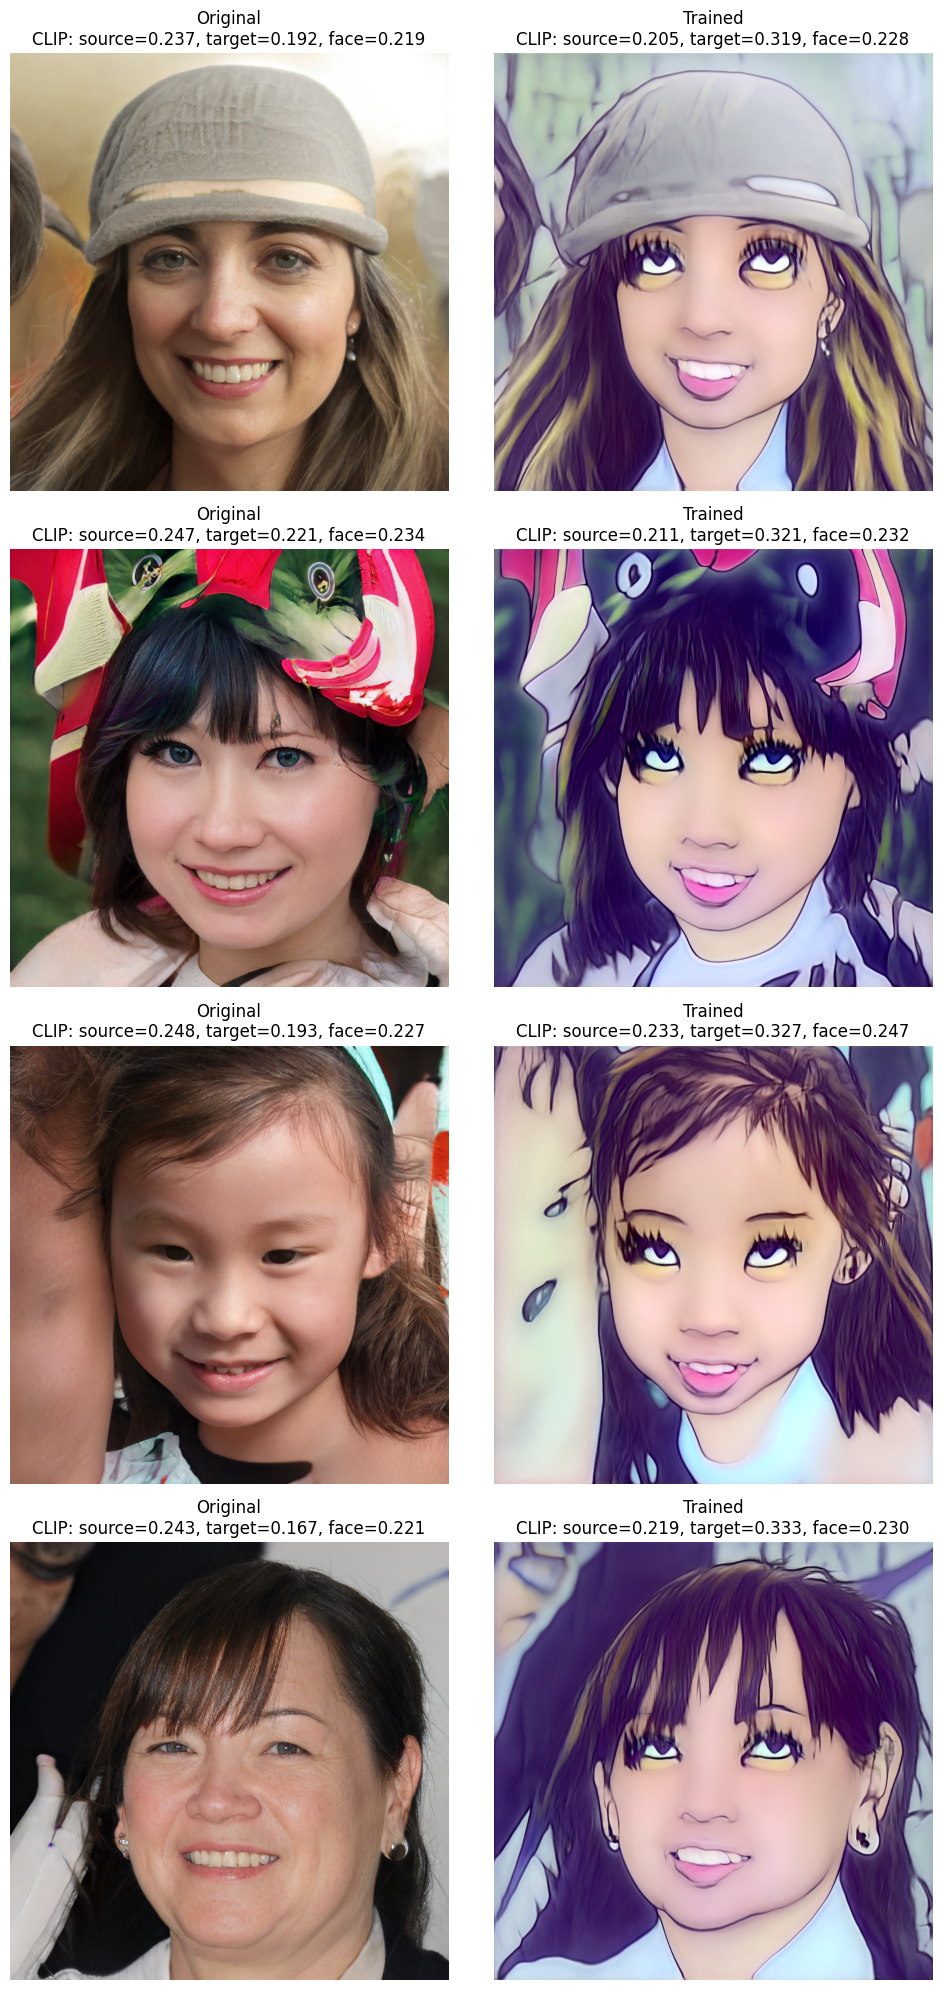

In [17]:
G_frozen.eval()
G_train.eval()
with torch.no_grad():
    z = torch.randn(4, latent_dim, device=device)
    w = G_frozen.style(z)
    imgs_frozen, _ = G_frozen([w], input_is_latent=True)
    imgs_train, _ = G_train([w], input_is_latent=True)

    # Compute CLIP similarities for source, target, and "face" text
    E_t_s = E_t_source / E_t_source.norm(dim=-1, keepdim=True)
    E_t_t = E_t_target / E_t_target.norm(dim=-1, keepdim=True)
    t_face = clip.tokenize(["face"]).to(device)
    E_t_face = clip_model.encode_text(t_face) / clip_model.encode_text(t_face).norm(dim=-1, keepdim=True)

    def clip_sims(imgs, E_s, E_t, E_face):
        img_clip = preprocess_for_clip(imgs)
        enc = clip_model.encode_image(img_clip)
        enc = enc / enc.norm(dim=-1, keepdim=True)
        sim_source = (enc * E_s.expand(enc.shape[0], -1)).sum(dim=-1)
        sim_target = (enc * E_t.expand(enc.shape[0], -1)).sum(dim=-1)
        sim_face = (enc * E_face.expand(enc.shape[0], -1)).sum(dim=-1)
        return sim_source.cpu().numpy(), sim_target.cpu().numpy(), sim_face.cpu().numpy()

    sim_src_frozen, sim_tgt_frozen, sim_face_frozen = clip_sims(imgs_frozen, E_t_s, E_t_t, E_t_face)
    sim_src_train, sim_tgt_train, sim_face_train = clip_sims(imgs_train, E_t_s, E_t_t, E_t_face)

def to_np(tensor):
    x = (tensor.clamp(-1, 1) + 1) / 2
    return x.squeeze(0).permute(1, 2, 0).cpu().numpy()

fig, axes = plt.subplots(4, 2, figsize=(10, 20))
for i in range(4):
    axes[i, 0].imshow(to_np(imgs_frozen[i:i+1]))
    axes[i, 0].axis("off")
    axes[i, 0].set_title(f"Original\nCLIP: source={sim_src_frozen[i]:.3f}, target={sim_tgt_frozen[i]:.3f}, face={sim_face_frozen[i]:.3f}")
    axes[i, 1].imshow(to_np(imgs_train[i:i+1]))
    axes[i, 1].axis("off")
    axes[i, 1].set_title(f"Trained\nCLIP: source={sim_src_train[i]:.3f}, target={sim_tgt_train[i]:.3f}, face={sim_face_train[i]:.3f}")
plt.tight_layout()
plt.show()